# First script inversion of the ZNS parameters

Thanks to this script we will carry out an inversion of the parameters of the unsaturated area, the porosity and the depth of the water table in steady state from a reference simulation sampled in 100 points. The heat transfer takes place in a one-dimensional soil of height 1m represented. 

The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the alpha Van Genuchten parameter $\alpha$,
- the $n$ Van Genuchten parameter, 
- the residual saturation $s_wres$, and
- the water table altitude (WT).


Fill the E_temperature_initiale.dat with the initial temperature profile





# O. Initiation Ginbette files

In [2]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import itertools
libs_gfortran = ['gfortran']
# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/1D_col_2/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../src/ginette_V2.f"])  #creat

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=2

# state
## 0 steady state
# 1 transient state (dynamic state)
state=1

# size columnin meter
z_top=1

#discretisation : size cell in meter
dz=0.01

#apply unsaturated flow and thermal 
#unsat =1 apply
#unsat=0 cancel unsaturated zone
unsat=1

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=1

# number of cell
nb_cell=z_top/dz
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
setup_model=setup_model.replace('[az]','%7.3e' % z_top)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)
setup_model=setup_model.replace('[unsat]','%1i' % unsat)

f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()

#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
val_k=3.33333333333333e-15
# solid grain density rho_s=val_r  [kg.m-3]
val_r=2578


Current working directory: /home/ariviere/Programmes/ginette/application/1D_col_2
ginette exist




## 1. Reference simulation and sampling

We choose to use the average parameters given by Carsel and Parrish (1988) as reference values for all facies


In [4]:
import numpy as np
import pandas as pd
import array

# porosity
REF_n=0.38 # \Phi

# Van Genuchten parameters
REF_a=7.50000 #m-1 alpha_vg
REF_nVG= 5.00  # n_vg
REF_swres=0.01 # S_wr

# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 

REF_r=1600
REF_c=2650
REF_l=5 #

# Boundary condition water level (meter)
REF_WT=0.4



# Initial conditions
f_IC_bck=open("E_cdt_initiale_backup.dat","r")
IC_model=f_IC_bck.read()
IC_model=IC_model.replace('[head_ini]', '%05.2fD+00' % REF_WT)
## write the boundary conditions
f_bc_bck=open("E_cdt_aux_limites_backup.dat", "r")
bc_model=f_bc_bck.read()
bc_model=bc_model.replace('[top]', '%08.2fD+00' % REF_WT)
bc_model=bc_model.replace('[bot]','%08.2fD+00' % REF_WT)
    ########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
f_paramZ_new = open("E_zone_parameter.dat", 'w')
f_bc_new = open("E_cdt_aux_limites.dat", 'w')
f_IC_new=open("E_cdt_initiale.dat","w")
param_zone=f_paramZ_bck.read()
coord=pd.DataFrame()    
#coord = pd.read_csv(f_coor, names=["id", "x", "z"], header=None, delim_whitespace=True)

# replace the parameter values
param_zone=param_zone.replace('[k1]','%8.2e' % val_k)
param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
param_zone=param_zone.replace('[r1]','%6.2f' % val_r)
param_zone=param_zone.replace('[a1]','%8.2e' % REF_a)
param_zone=param_zone.replace('[nVG1]','%6.2f' % REF_nVG)
param_zone=param_zone.replace('[swres1]','%6.2f' % REF_swres)
param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
param_zone=param_zone.replace('[c1]','%6.2f' % REF_c)
param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)
    
# calculate the coordinates to know the number of cell in the domain    
zvalues = np.arange(dz/2, z_top,dz );
xvalues = np.array([0.5]);
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
    "x": np.reshape(xx,NT),
    "z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1



#Write new ginette files
f_IC_new.write(IC_model)
f_paramZ_new.write(param_zone)
f_bc_new.write(bc_model)
coord.zone.to_csv(f_zone, index = False, header=False)
    
# close files    
f_zone.close()
f_coor.close()
f_paramZ_new.close()
f_paramZ_bck.close()

f_IC_new.close()
f_bc_bck.close()
f_bc_new.close()
f_coor.close()


# run ginette
subprocess.call(["./ginette"])
    




./ginette: error while loading shared libraries: libgfortran.so.4: cannot open shared object file: No such file or directory


127

# Profile saturation référence au bout de 2 jours

In [5]:
# read the saturation profil   
saturation_profile_REF = pd.read_table('S_saturation_profil_t.dat',delim_whitespace=True,header=None)
saturation_profile_REF.columns=[ "time",  "z","sat"]
saturation_profile_REF=saturation_profile_REF.iloc[saturation_profile_REF.index.stop-int(nb_cell):saturation_profile_REF.index.stop]


/tmp/ipykernel_103211/3646361116.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


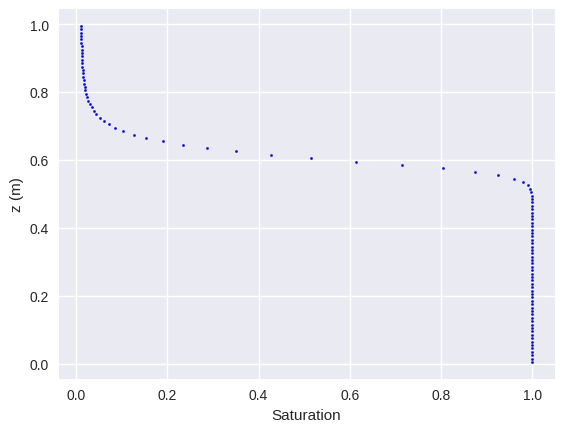

In [6]:
plt.figure()
plt.style.use('seaborn')

plt.scatter(saturation_profile_REF.sat,saturation_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
plt.xlabel('Saturation')
plt.xlabel('Saturation')
plt.ylabel('z (m)')
plt.show()

 # Profile de temperature au bout de 2 jours

/tmp/ipykernel_103211/1267379805.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


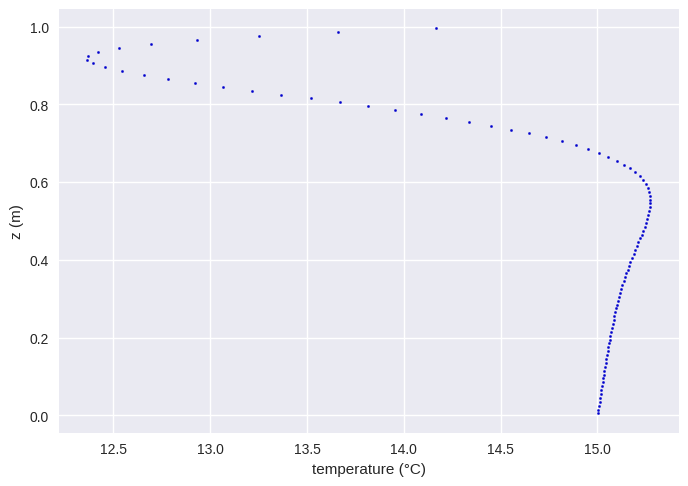

In [7]:
# read the temperature profile   
temperature_profile_REF = pd.read_table('Sim_temperature_profil_t.dat',delim_whitespace=True,header=None)
temperature_profile_REF.columns=[ "time",  "z","temp"]
temperature_profile_REF=temperature_profile_REF.iloc[temperature_profile_REF.index.stop-int(nb_cell):temperature_profile_REF.index.stop]

plt.figure()
plt.style.use('seaborn')

plt.scatter(temperature_profile_REF.temp,temperature_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
plt.xlabel('temperature (°C)')
plt.ylabel('z (m)')
plt.show()


## 2. Screening parmeters
### 2.1 Range definition


In [183]:
dvt_a = 4 
dvt_nVG = 4
dvt_swres = 0.1
dvt_n = 0.1
dvt_WT = 0.2
dvt_l=4
dvt_c=100


range_a = [REF_a-dvt_a,REF_a+dvt_a]
range_nVG =  [REF_nVG-dvt_nVG,REF_nVG+dvt_nVG]
range_swres =  [REF_swres-dvt_swres,REF_swres+dvt_swres]
range_n =  [REF_n-dvt_n,REF_n+dvt_n]
range_WT =  [REF_WT-dvt_WT,REF_WT+dvt_WT]
range_l =  [REF_l-dvt_l,REF_l+dvt_l]

### 2.2 Paramétrisation

Choice of step values for each of the parameters, the measurement error and the number of sample. The following values are proposed as a first intention, they can be modified if necessary.

In [184]:
i_a = 4
i_nVG = 0.5
i_swres = 0.1
i_n = 0.1
i_WT = 0.1
i_l=1

### 2.3 loop table param
Later, you will use a loop of i over param_all


In [185]:
df = pd.DataFrame()
param_all=["a","nVG",'l']
param=["l"]
for i in param:
    df[i] = np.arange(eval('range_{}'.format(i))[0],eval('range_{}'.format(i))[1]+eval('i_{}'.format(i)),eval('i_{}'.format(i)))
    print(i)
    for x in param_all :
        if x != i:
            df[x] = eval('REF_{}'.format(x))

            

    
df.head(30)

l


,l,a,nVG
0,1,7.5,5.0
1,2,7.5,5.0
2,3,7.5,5.0
3,4,7.5,5.0
4,5,7.5,5.0
5,6,7.5,5.0
6,7,7.5,5.0
7,8,7.5,5.0
8,9,7.5,5.0


### 2.5 Misfit function

In [169]:
def rmse(predictions, ref,sigma):
    differences = ((predictions - ref)/sigma)                      #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val

### 2.6 loops of simulations

One you're sure all steps work correctly, you will uncoment the loop over the whole table of parameters. Replace all row_1 by df

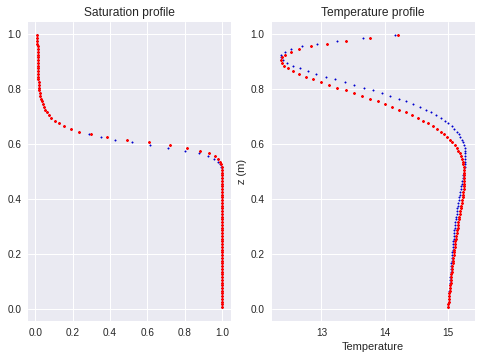

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(saturation_profile_REF.sat,saturation_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
ax1.set_title('Saturation profile')
plt.xlabel('Saturation')
plt.ylabel('z (m)')
ax2.set_title('Temperature profile')
ax2.scatter(temperature_profile_REF.temp,temperature_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
plt.xlabel('Temperature')
plt.ylabel('z (m)')




#row_1=df.head(1)
df["s"] = ""
for index, row in df.iterrows():
# Initial conditions
    f_IC_bck=open("E_cdt_initiale_backup.dat","r")
    IC_model=f_IC_bck.read()
    IC_model=IC_model.replace('[head_ini]', '%05.2fD+00' % REF_WT)
## write the boundary conditions
    f_bc_bck=open("E_cdt_aux_limites_backup.dat", "r")
    bc_model=f_bc_bck.read()
    bc_model=bc_model.replace('[top]', '%08.2fD+00' % REF_WT)
    bc_model=bc_model.replace('[bot]','%08.2fD+00' % REF_WT)
    ########### Zone of parameters
    f_coor=open("E_coordonnee.dat", "w")
    f_zone=open("E_zone.dat", 'w')
    f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
    f_paramZ_new = open("E_zone_parameter.dat", 'w')
    f_bc_new = open("E_cdt_aux_limites.dat", 'w')
    f_IC_new=open("E_cdt_initiale.dat","w")
    param_zone=f_paramZ_bck.read()
   
#coord = pd.read_csv(f_coor, names=["id", "x", "z"], header=None, delim_whitespace=True)

# replace the parameter values
# If you wand add more parameters modify this section
    param_zone=param_zone.replace('[k1]','%8.2e' % val_k)
    param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
    param_zone=param_zone.replace('[r1]','%6.2f' % val_r)
    param_zone=param_zone.replace('[a1]','%8.2e' % row['a'])
    param_zone=param_zone.replace('[nVG1]','%6.2f' % row['nVG'])
    param_zone=param_zone.replace('[swres1]','%6.2f' % REF_swres)
    param_zone=param_zone.replace('[l1]','%6.2f' % row['l'])
    param_zone=param_zone.replace('[c1]','%6.2f' % REF_c)
    param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)
    




#Write new ginette files
    f_IC_new.write(IC_model)
    f_paramZ_new.write(param_zone)
    f_bc_new.write(bc_model)

    
# close files    


    f_paramZ_new.close()
    f_paramZ_bck.close()

    f_IC_new.close()
    f_bc_bck.close()
    f_bc_new.close()



# run ginette
    subprocess.call(["./ginette"])
    
# read the saturation profil   
    saturation_profile = pd.read_table('S_saturation_profil_t.dat',delim_whitespace=True,header=None)
    saturation_profile.columns=[ "time",  "z","sat"]
    saturation_profile=saturation_profile.iloc[saturation_profile.index.stop-int(nb_cell):saturation_profile.index.stop]
    temperature_profile = pd.read_table('Sim_temperature_profil_t.dat',delim_whitespace=True,header=None)
    temperature_profile.columns=[ "time",  "z","temp"]
    temperature_profile=temperature_profile.iloc[temperature_profile.index.stop-int(nb_cell):temperature_profile.index.stop]
    #df["s"].at[index ] = rmse(saturation_profile['sat'],saturation_profile_REF['sat'],0.02)
    
    ax1.scatter(saturation_profile.sat,saturation_profile.z, s=10, alpha=1, color='red',marker='.')
    ax1.set_title('Saturation profile')
    plt.xlabel('Saturation')
    plt.ylabel('z (m)')
    ax2.set_title('Temperature profile')
    ax2.scatter(temperature_profile.temp,temperature_profile.z, s=10, alpha=1, color='red',marker='.')
    plt.xlabel('Temperature')
    plt.ylabel('z (m)')


plt.show()


In [171]:
temperature_profile.temp

19100    14.166618
19101    13.657962
19102    13.250023
19103    12.932254
19104    12.694578
           ...    
19195    15.013939
19196    15.010834
19197    15.007735
19198    15.004640
19199    15.001546
Name: temp, Length: 100, dtype: float64